# HIV Model Sample Solution

Implements the model described in Phillips (1996), "Reduction of HIV Concentration During Acute Infection: Independence from a Specific Immune Response," _Science_ 271:497-499.

Copyright 2018 Allen Downey and Jason Woodard

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

## Basic Solution (Euler's method with explicit dt)

The simulation function is cut and pasted from lotka-volterra.ipynb:

In [2]:
def run_simulation(system, update_func):
    """Runs a simulation of the system.
        
    system: System object
    update_func: function that updates state
    
    returns: TimeFrame
    """
    unpack(system)

    frame = TimeFrame(columns=init.index)
    frame.row[t0] = init
    
    for t in linrange(t0, t_end, dt):
        frame.row[t+dt] = update_func(frame.row[t], t, system)
    
    return frame

The update function is adapted from the "Eulerized" Lotka-Volterra model we showed in class on Day 21 (slide 16). Note that there is a typo in the paper, where "p" in Equation 2 should actually be rho.

In [3]:
def update_func(state, t, system):
    """Update the HIV model.
    
    state: State(R, L, E, V)
    t: time
    system: System object
    
    returns: State(R, L, E, V)
    """
    unpack(system)
    R, L, E, V = state

    # These slope equations are taken straight from the paper (p. 497)
    dRdt = (Gamma * tau) - (mu * R) - (beta * R * V)
    dLdt = (rho * beta * R * V) - (mu * L) - (alpha * L)
    dEdt = (1 - rho) * (beta * R * V) + (alpha * L) - (delta * E)
    dVdt = (pi * E) - (sigma * V)
    
    # Be sure that the slopes are multiplied by dt to compute the total changes
    R += dRdt * dt
    L += dLdt * dt
    E += dEdt * dt
    V += dVdt * dt
    
    # Be sure that a new State object is returned, not just a tuple
    return State(R=R, L=L, E=E, V=V)

Determining the initial conditions is a little bit tricky.

The initial value of R can be read off Figure 1(B), and can also be inferred from the fact that there are assumed to be 1000 CD4 lymphocytes in the notional quantity of tissue or blood, of which a fraction tau = 0.2 are activated.

The (zero) initial values of L and E can be inferred from the statement in the first column of p. 497 that "there were initially no infected cells."

The initial value of V is stated in the caption for Figure 1. (Note that 100 is incorrect, since that is the whole-body total. The caption for Table 1 states that "we are considering around 1/(2.5 x 10^8) of the whole body," and 1/2.5e8*100 = 4e-7.)

In [4]:
init = State(R=200, L=0, E=0, V=4e-7)

,values
R,2.000000e+02
L,0.000000e+00
E,0.000000e+00
V,4.000000e-07


The system parameters are taken directly from Table 1, except for t0 and t_end (which are taken from Figure 1), and dt (which was adjusted by hand to produce smooth-looking curves in a reasonable running time).

In [5]:
system = System(Gamma=1.36,
                mu=1.36e-3,
                tau=0.2,
                beta=0.00027,
                rho=0.1,
                alpha=3.6e-2,
                sigma=2,
                delta=0.33,
                pi=100,
                t0=0,
                t_end=120,
                dt=0.1)

,values
Gamma,1.36000
mu,0.00136
tau,0.20000
beta,0.00027
rho,0.10000
alpha,0.03600
sigma,2.00000
delta,0.33000
pi,100.00000
t0,0.00000


Good practice -- always test your update function with the initial conditions! Please make sure students do this.

In [6]:
update_func(init, 0, system)

,values
R,2.000000e+02
L,2.160000e-10
E,1.944000e-09
V,3.200000e-07


And here we go, again exactly as in the Lotka-Volterra example.

In [7]:
results = run_simulation(system, update_func)
results.head()

,R,L,E,V
0.0,200.0,0.000000e+00,0.000000e+00,4.000000e-07
0.1,200.0,2.160000e-10,1.944000e-09,3.200000e-07
0.2,200.0,3.879930e-10,3.435826e-09,2.754400e-07
0.3,200.0,5.352811e-10,4.662479e-09,2.547103e-07
0.4,200.0,6.708248e-10,5.748436e-09,2.503930e-07


Note that plotting all four stocks on the same vertical axis isn't super informative because of the different orders of magnitude, but it at least gives us the sense that something reasonable is happening.

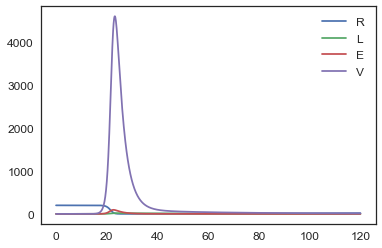

In [8]:
results.plot()

Let's take a look at R alone, and compare it to Figure 1(B):

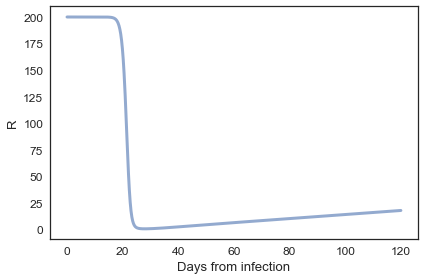

In [9]:
plot(results.R)
decorate(xlabel='Days from infection', ylabel='R')

Now let's plot L and E. (Note how we make a logged y-axis scale. We also adjust the axis range to make it look more like the paper, and we use the colors C1 and C2 so they are consistent with the results plot above. We don't expect students to do these things, but it's a good chance to develop skills that are useful in the projects.)

[0, 120, 0.1, 100.0]

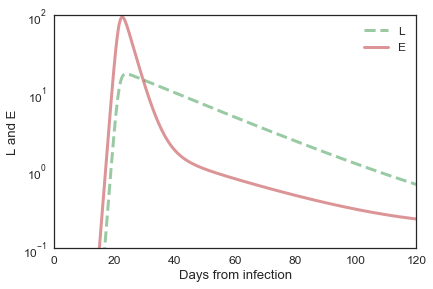

In [10]:
plot(results.L, 'C1--', label='L')
plot(results.E, 'C2-', label='E')
decorate(xlabel='Days from infection', ylabel='L and E', yscale='log')
plt.axis([0, 120, 1e-1, 1e2])

And now V, the same way:

[0, 120, 0.1, 10000.0]

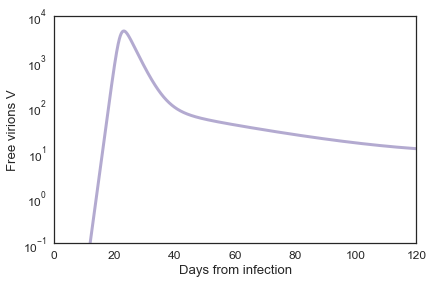

In [11]:
plot(results['V'], 'C3')
decorate(xlabel='Days from infection', ylabel='Free virions V', yscale='log')
plt.axis([0, 120, 1e-1, 1e4])

Note that the number of CD4 lymphocytes is not modeled as a single stock but rather the sum of stocks, as explained in the text (right column of p. 497) and the caption to Figure 1. We can easily compute and plot it to reproduce the curve in Figure 1(A).

In [12]:
CD4_lymphocytes = (1000 * (1 - system.tau)) + results['R'] + results['L'] + results['E']
CD4_lymphocytes.head()

0.0    1000.0
0.1    1000.0
0.2    1000.0
0.3    1000.0
0.4    1000.0
dtype: float64

[0, 120, 600, 1200]

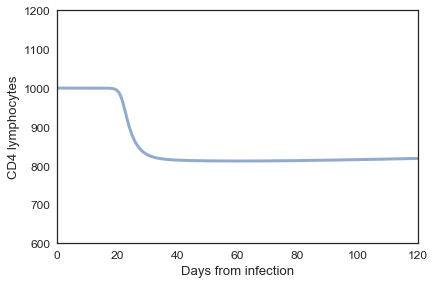

In [13]:
plot(CD4_lymphocytes)
decorate(xlabel='Days from infection', ylabel='CD4 lymphocytes')
plt.axis([0, 120, 600, 1200])

## Optional Solution (using ODE solver)

Based on chap13ode.ipynb (see Day 23 slides) and the update function above.

In [14]:
def slope_func(state, t, system):
    """Compute slopes for the the HIV model.
    
    state: State(R, L, E, V)
    t: time
    system: System object
    
    returns: four derivatives
    """
    unpack(system)
    R, L, E, V = state

    # These slope equations are taken straight from the paper (p. 497)
    dRdt = (Gamma * tau) - (mu * R) - (beta * R * V)
    dLdt = (rho * beta * R * V) - (mu * L) - (alpha * L)
    dEdt = (1 - rho) * (beta * R * V) + (alpha * L) - (delta * E)
    dVdt = (pi * E) - (sigma * V)
    
    # Now we are *only* returning a tuple, not a new State objet
    return dRdt, dLdt, dEdt, dVdt

Note that run_ode_solver requires that the initial condition be included in the System object. (If students don't do that, they'll get an error like I did :-)

In [15]:
system = System(init=init,
                Gamma=1.36,
                mu=1.36e-3,
                tau=0.2,
                beta=0.00027,
                rho=0.1,
                alpha=3.6e-2,
                sigma=2,
                delta=0.33,
                pi=100,
                t0=0,
                t_end=120,
                dt=0.1)

,values
init,R 2.000000e+02 L 0.000000e+00 E 0.000...
Gamma,1.36
mu,0.00136
tau,0.2
beta,0.00027
rho,0.1
alpha,0.036
sigma,2
delta,0.33
pi,100


In [16]:
results_with_ode_solver, details = run_ode_solver(system, slope_func)
details

,values
sol,None
t_events,[]
nfev,662
njev,0
nlu,0
status,0
message,The solver successfully reached the end of the...
success,True


Woohoo, success! Let's see what the results look like:

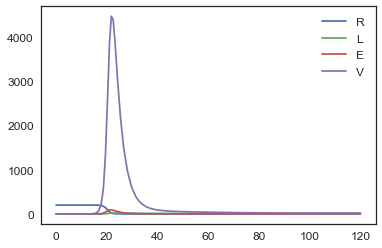

In [17]:
results_with_ode_solver.plot()

Okay, they look pretty much like the results from Euler's method with dt=0.1 day, so we won't plot the individual stocks again ...